In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_wine




# Dataset


In [2]:
data = load_wine()
df = pd.DataFrame(data.data, columns=data.feature_names)
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


## Correlation

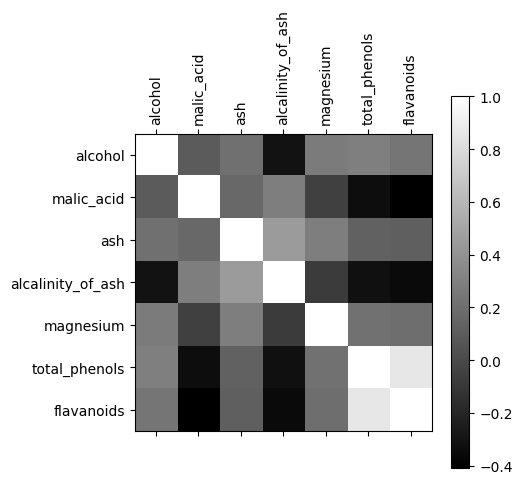

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids
alcohol,1.000000,0.094397,0.211545,-0.310235,0.270798,0.289101,0.236815
malic_acid,0.094397,1.000000,0.164045,0.288500,-0.054575,-0.335167,-0.411007
ash,0.211545,0.164045,1.000000,0.443367,0.286587,0.128980,0.115077
alcalinity_of_ash,-0.310235,0.288500,0.443367,1.000000,-0.083333,-0.321113,-0.351370
magnesium,0.270798,-0.054575,0.286587,-0.083333,1.000000,0.214401,0.195784
total_phenols,0.289101,-0.335167,0.128980,-0.321113,0.214401,1.000000,0.864564
flavanoids,0.236815,-0.411007,0.115077,-0.351370,0.195784,0.864564,1.000000


In [3]:
names = df.columns[:7]
corr_mtx = (df[names]).corr(method='pearson')
plt.matshow(corr_mtx, cmap="grey")
plt.colorbar()

plt.xticks(range(len(names)), names, rotation=90)
plt.yticks(range(len(names)), names)
plt.show()

corr_mtx

## Data Split


(124, 13)
(54, 13)
(124,)
(54,)


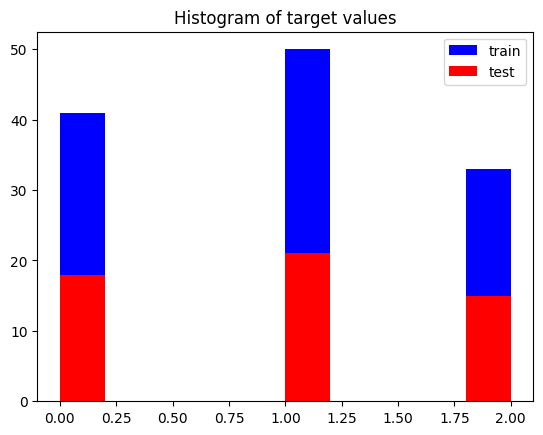

In [4]:
from sklearn.model_selection import train_test_split
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

plt.hist(y_train, color='blue', label='train')
plt.hist(y_test, color='red', label='test')
plt.title('Histogram of target values')
plt.legend()
plt.show()

# Training - without Optuna


## Metric function

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    roc_auc_score,
    accuracy_score,
    precision_score,  # Dodano Precision
    recall_score      # Dodano Recall dla ułatwienia
)
from sklearn.preprocessing import label_binarize
from itertools import cycle

def metrics_multiclass(y_true: np.ndarray, y_pred_classes: np.ndarray, y_pred_scores: np.ndarray, method: str) -> pd.DataFrame:
    """
    Calculates and plots classification metrics (Accuracy, Precision, Recall, Specificity, AUC)
    for multiclass classification, displaying results in a Pandas DataFrame table.

    Args:
        y_true (np.ndarray): True labels (ground truth).
        y_pred_classes (np.ndarray): Predicted class labels.
        y_pred_scores (np.ndarray): Predicted probabilities (or decision scores) for each class.
                                     Shape should be (n_samples, n_classes).
        method (str): Name of the classification method (for plot title).

    Returns:
        pd.DataFrame: A DataFrame containing the combined per-class and macro-averaged metrics.
    """

    classes = np.unique(y_true)
    n_classes = len(classes)

    # ----------------------------------------------------
    # 1. Obliczenia
    # ----------------------------------------------------

    accuracy = accuracy_score(y_true, y_pred_classes)
    cf_mtx = confusion_matrix(y_true, y_pred_classes)

    # Scikit-learn calculation (easier and more robust)
    recall_per_class = recall_score(y_true, y_pred_classes, average=None, zero_division=0)
    precision_per_class = precision_score(y_true, y_pred_classes, average=None, zero_division=0)

    # Ręczne obliczenie Specyficzności (One-vs-Rest)
    specificity_per_class = []
    for i in range(n_classes):
        TP = cf_mtx[i, i]
        FN = np.sum(cf_mtx[i, :]) - TP
        FP = np.sum(cf_mtx[:, i]) - TP
        TN = np.sum(cf_mtx) - (TP + FN + FP)

        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        specificity_per_class.append(specificity)

    # Obliczenie AUC (One-vs-Rest)
    y_true_bin = label_binarize(y_true, classes=classes)
    roc_auc_per_class = []

    # Collect AUC for plotting and report
    for i in range(n_classes):
        roc_auc_class = roc_auc_score(y_true_bin[:, i], y_pred_scores[:, i])
        roc_auc_per_class.append(roc_auc_class)

    roc_area_macro = roc_auc_score(y_true_bin, y_pred_scores, multi_class='ovr', average='macro')

    # ----------------------------------------------------
    # 2. Tworzenie DataFrame z Metrykami
    # ----------------------------------------------------

    # Metryki dla każdej klasy
    df_per_class = pd.DataFrame({
        'Klasa': classes,
        'Czułość (Recall)': recall_per_class,
        'Precyzja (Precision)': precision_per_class,
        'Specyficzność': specificity_per_class,
        'AUC (OvR)': roc_auc_per_class
    })

    # Metryki Uśrednione
    macro_row = pd.DataFrame({
        'Klasa': ['Macro-Avg', 'Accuracy (overall)'],
        'Czułość (Recall)': [np.mean(recall_per_class), np.nan],
        'Precyzja (Precision)': [np.mean(precision_per_class), np.nan],
        'Specyficzność': [np.mean(specificity_per_class), np.nan],
        'AUC (OvR)': [roc_area_macro, np.nan]
    })

    # Metryka Ogólna (Accuracy)
    accuracy_row = pd.DataFrame({
        'Klasa': ['Accuracy (overall)'],
        'Czułość (Recall)': [np.nan],
        'Precyzja (Precision)': [np.nan],
        'Specyficzność': [np.nan],
        'AUC (OvR)': [np.nan]
    })

    # Łączenie i dodanie Accuracy w osobnym wierszu
    df_metrics = pd.concat([df_per_class, macro_row]).reset_index(drop=True)
    df_metrics.loc[df_metrics['Klasa'] == 'Accuracy (overall)', 'Czułość (Recall)'] = accuracy # Używamy dowolnej komórki 'Overall' do wstawienia Accuracy
    df_metrics.loc[df_metrics['Klasa'] == 'Accuracy (overall)', 'Precyzja (Precision)'] = accuracy
    df_metrics.loc[df_metrics['Klasa'] == 'Accuracy (overall)', 'Specyficzność'] = accuracy
    df_metrics.loc[df_metrics['Klasa'] == 'Accuracy (overall)', 'AUC (OvR)'] = accuracy
    df_metrics.rename(columns={'Czułość (Recall)': 'Recall',
                               'Precyzja (Precision)': 'Precision',
                               'Specyficzność': 'Specifity',
                               'AUC (OvR)': 'AUC_score'}, inplace=True)

    # Wyróżnienie wierszy
    # Wyczyszczenie NaN
    df_metrics = df_metrics.fillna('')

    # ----------------------------------------------------
    # 3. Plotting
    # ----------------------------------------------------

    # Używamy większego figsize
    fig, ( ax_matrix, ax_roc) = plt.subplots(1, 2, figsize=(22, 6))

    # 1. Confusion Matrix Display
    cf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx, display_labels=classes)
    cf_mtx_disp.plot(ax=ax_matrix, cmap='grey', values_format='d')
    ax_matrix.set_title("Macierz Pomyłek", fontsize=14)

    # 3. ROC Curve Display (Plotting OvR for each class)
    ax_roc.set_title(f'Krzywe ROC (One-vs-Rest)\nMacro AUC: {roc_area_macro:.4f}', fontsize=14)
    ax_roc.plot([0, 1], [0, 1], 'k--', label='Losowy (AUC = 0.5)', alpha=0.6) # Diagonal line

    # Calculate and plot ROC for each class
    colors = cycle(['blue', 'red', 'green', 'purple', 'orange']) # Dodałem więcej kolorów na wszelki wypadek
    for i, color in zip(range(n_classes), colors):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_scores[:, i])

        ax_roc.plot(
            fpr,
            tpr,
            linewidth=2,
            label=f'Klasa {classes[i]} (AUC: {roc_auc_per_class[i]:.2f})',
            color=color,
            alpha=0.7
        )

    ax_roc.set_xlabel('Odsetek Fałszywie Pozytywnych (FPR)')
    ax_roc.set_ylabel('Czułość (TPR)')
    ax_roc.legend(loc="lower right", fontsize=9)
    ax_roc.grid(linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    # Zwrócenie skonsolidowanego DataFrame
    return df_metrics



model_performence = {}

## Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression
help(LogisticRegression.fit)

Help on function fit in module sklearn.linear_model._logistic:

fit(self, X, y, sample_weight=None)
    Fit the model according to the given training data.
    
    Parameters
    ----------
    X : {array-like, sparse matrix} of shape (n_samples, n_features)
        Training vector, where `n_samples` is the number of samples and
        `n_features` is the number of features.
    
    y : array-like of shape (n_samples,)
        Target vector relative to X.
    
    sample_weight : array-like of shape (n_samples,) default=None
        Array of weights that are assigned to individual samples.
        If not provided, then each sample is given unit weight.
    
        .. versionadded:: 0.17
           *sample_weight* support to LogisticRegression.
    
    Returns
    -------
    self
        Fitted estimator.
    
    Notes
    -----
    The SAGA solver supports both float64 and float32 bit arrays.



In [7]:
from sklearn.linear_model import LogisticRegression
logic_base_model = LogisticRegression()
logic_base_model.fit(X_train, y_train, sample_weight=None)



/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

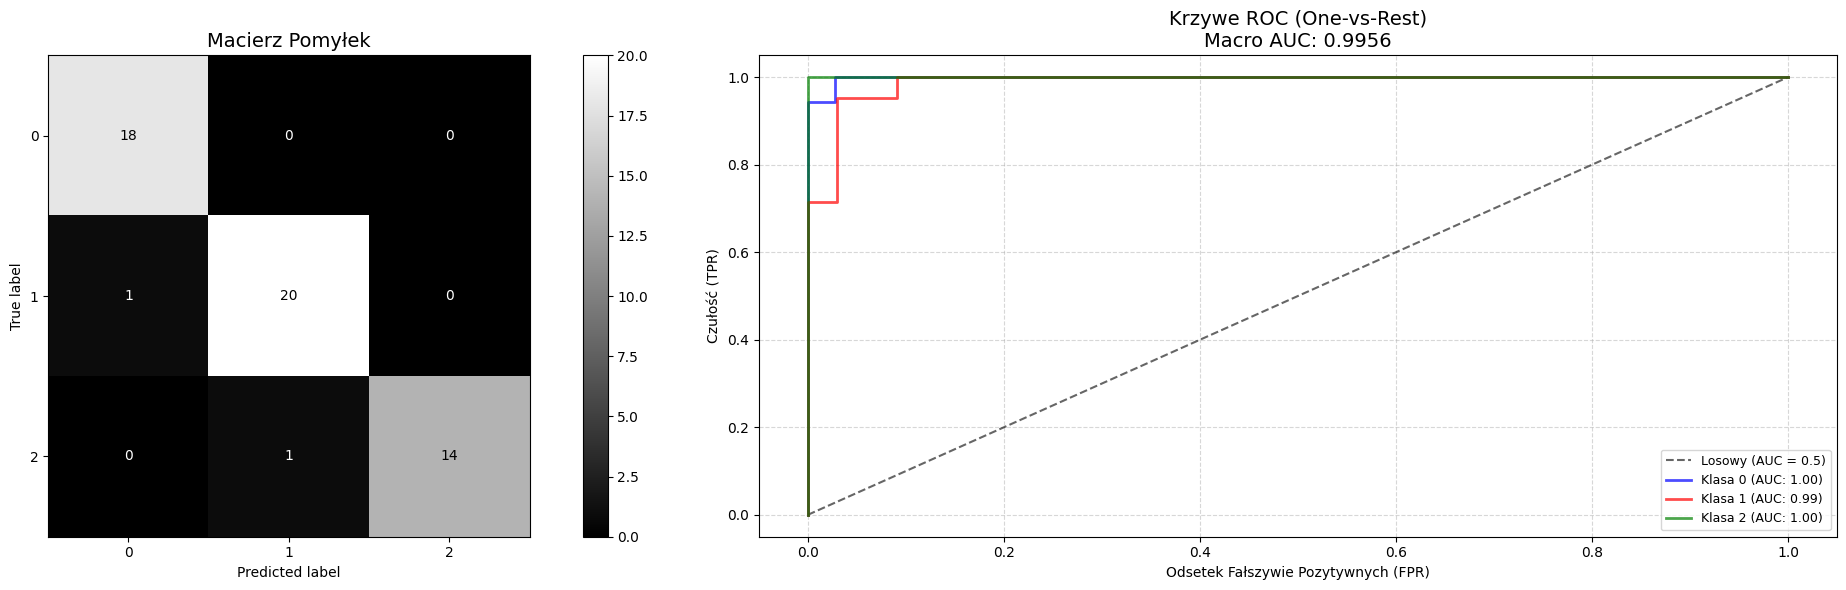

,Klasa,Recall,Precision,Specifity,AUC_score
0,0,1.000000,0.947368,0.972222,0.998457
1,1,0.952381,0.952381,0.969697,0.988456
2,2,0.933333,1.000000,1.000000,1.000000
3,Macro-Avg,0.961905,0.966583,0.980640,0.995638
4,Accuracy (overall),0.962963,0.962963,0.962963,0.962963


In [8]:
y_pred =logic_base_model.predict(X_test)
y_scores = logic_base_model.predict_proba(X_test)
model_performence['Logistic Base'] = metrics_multiclass(y_test, y_pred, y_scores, 'logistic base')
model_performence['Logistic Base']

## KNN

In [9]:
from sklearn.neighbors import KNeighborsClassifier
knn_base = KNeighborsClassifier()
knn_base.fit(X_train, y_train) #No sample_weight

KNeighborsClassifier()

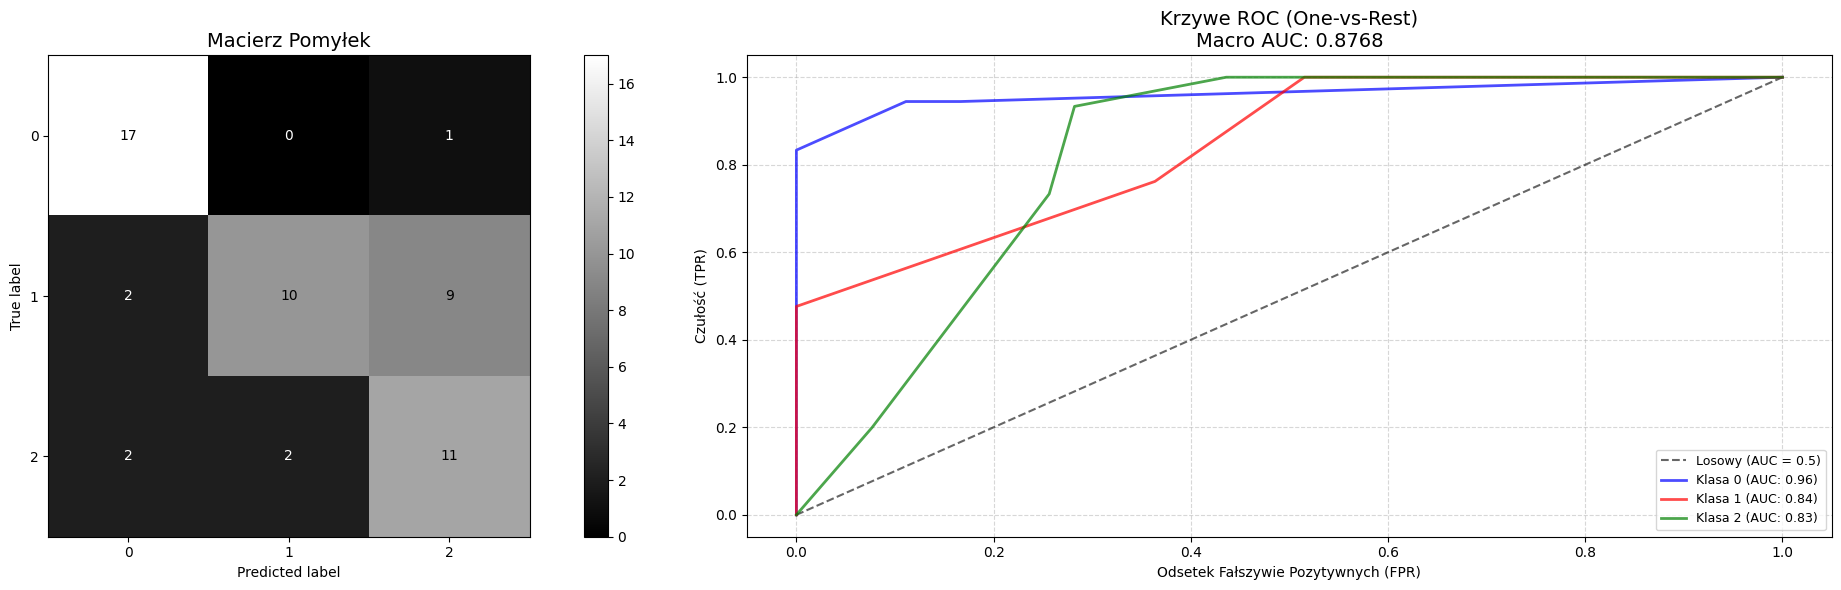

[0 0 1 2 1 1 2 2 0 1 0 0 2 0 2 0 0 2 0 0 2 2 2 2 2 0 0 0 0 0 0 0 2 1 2 2 0
 2 1 2 2 1 1 1 2 0 2 2 2 1 1 0 1 0]


In [10]:
y_pred =knn_base.predict(X_test)
y_scores = knn_base.predict_proba(X_test)
model_performence['KNN Base'] = metrics_multiclass(y_test, y_pred, y_scores, 'KNN base')
model_performence['KNN Base']

print(y_pred)

## LDA

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_base = LinearDiscriminantAnalysis()
lda_base.fit(X_train, y_train) #no sample weights

LinearDiscriminantAnalysis()

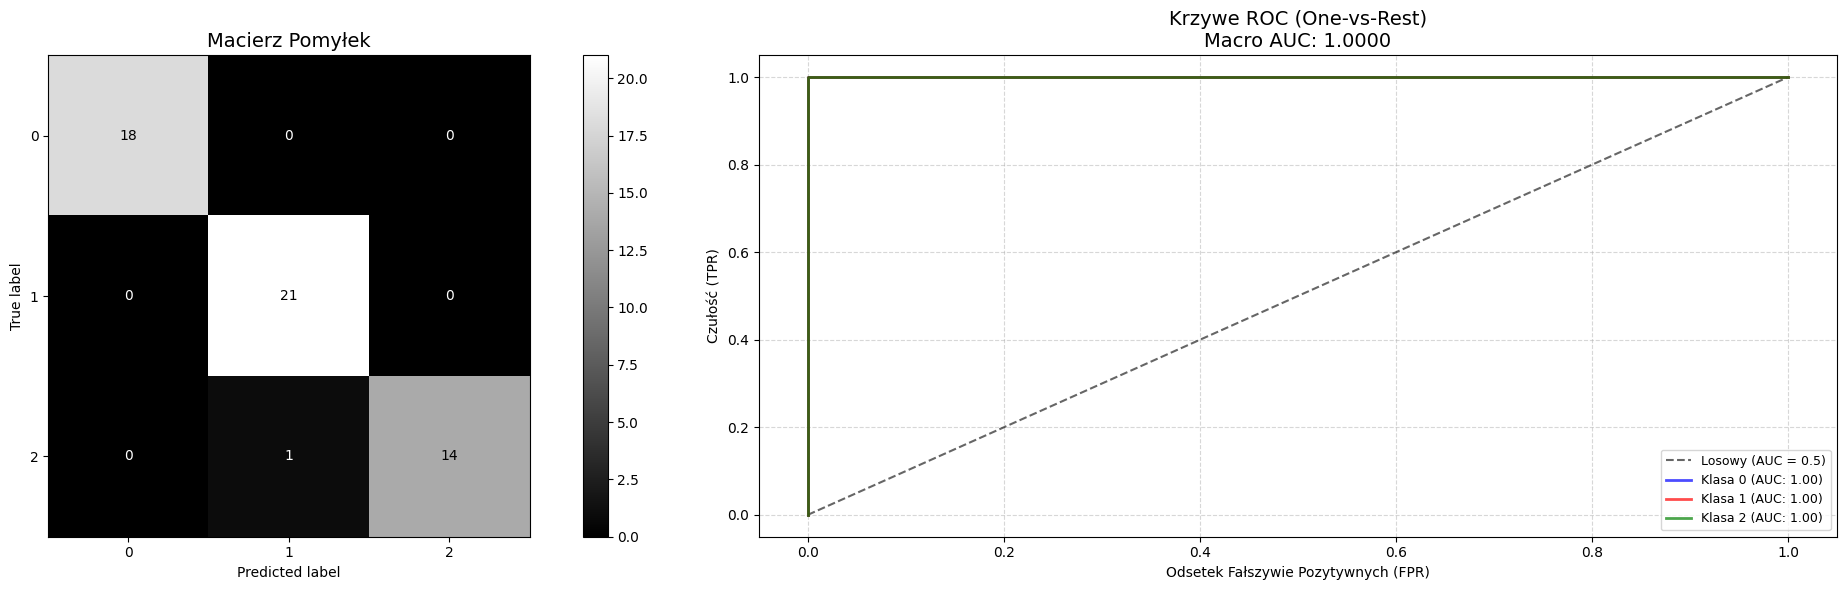

,Klasa,Recall,Precision,Specifity,AUC_score
0,0,1.000000,1.000000,1.000000,1.000000
1,1,1.000000,0.954545,0.969697,1.000000
2,2,0.933333,1.000000,1.000000,1.000000
3,Macro-Avg,0.977778,0.984848,0.989899,1.000000
4,Accuracy (overall),0.981481,0.981481,0.981481,0.981481


In [12]:
y_pred = lda_base.predict(X_test)
y_scores = lda_base.predict_proba(X_test)
model_performence['LDA Base'] = metrics_multiclass(y_test, y_pred, y_scores, 'LDA base')
model_performence['LDA Base']

# Hyperparameters Optuna

In [13]:
import optuna
from sklearn.model_selection import cross_val_score, StratifiedKFold

## define objective function

In [14]:
def objective_lr(trial):
    C = trial.suggest_float('C', 1e-3, 1e2, log=True)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'saga'])
    max_iter = trial.suggest_int('max_iter', 0, 200)

    clf = LogisticRegression(C=C, solver=solver, max_iter=max_iter, random_state=42)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy').mean()

    return score

## Creating and performing a study

In [15]:
study = optuna.create_study(direction="maximize")
study.optimize(objective_lr, n_trials=100)

study.best_params

[I 2025-11-25 14:42:20,969] A new study created in memory with name: no-name-fbf14d6e-8d0a-4c66-86f6-861e38a85482
[I 2025-11-25 14:42:21,092] Trial 0 finished with value: 0.9280000000000002 and parameters: {'C': 0.050129925339761724, 'solver': 'liblinear', 'max_iter': 49}. Best is trial 0 with value: 0.9280000000000002.
[I 2025-11-25 14:42:21,151] Trial 1 finished with value: 0.9276666666666665 and parameters: {'C': 0.13972675303292156, 'solver': 'liblinear', 'max_iter': 159}. Best is trial 0 with value: 0.9280000000000002.
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/franio/Desktop/Uczenie_maszynowe/venv/lib/python

{'C': 0.05858429990088127, 'solver': 'liblinear', 'max_iter': 55}

## Optimized model performance

In [16]:
better_rl_model = LogisticRegression(C=study.best_params['C'], solver=study.best_params['solver'], max_iter=study.best_params['max_iter'])
better_rl_model.fit(X_train, y_train)

LogisticRegression(C=0.05858429990088127, max_iter=55, solver='liblinear')

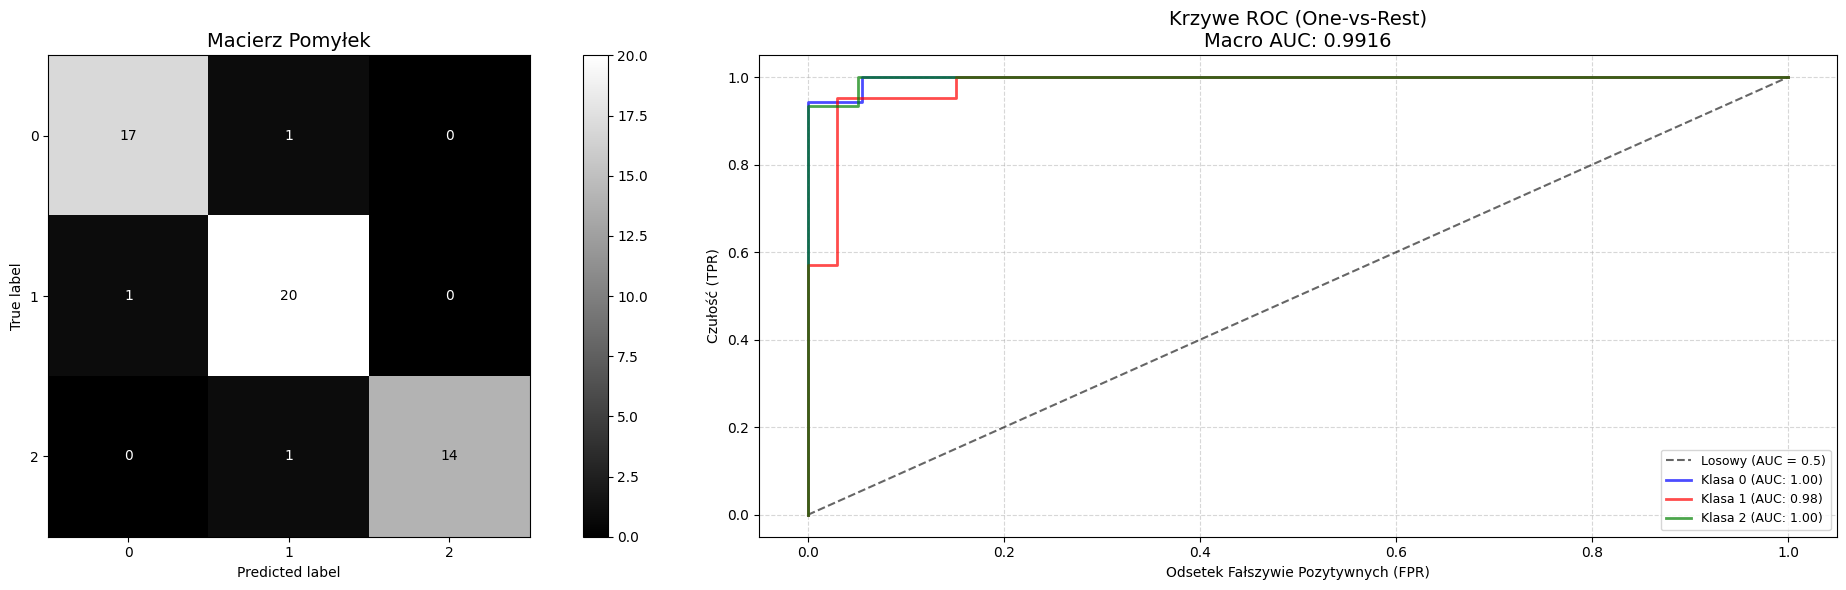

,Klasa,Recall,Precision,Specifity,AUC_score
0,0,0.944444,0.944444,0.972222,0.996914
1,1,0.952381,0.909091,0.939394,0.981241
2,2,0.933333,1.000000,1.000000,0.996581
3,Macro-Avg,0.943386,0.951178,0.970539,0.991579
4,Accuracy (overall),0.944444,0.944444,0.944444,0.944444


In [17]:
y_pred = better_rl_model.predict(X_test)
y_scores = better_rl_model.predict_proba(X_test)

model_performence['better Logistic'] = metrics_multiclass(y_test, y_pred, y_scores, 'better logic')
model_performence['better Logistic']

## Optimizing kNN

In [18]:
def object_knn(trail):
    n_neighbors = trail.suggest_int('n_neighbors', 1,80)
    weights = trail.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trail.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski', 'chebyshev'])

    clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, metric=metric)
    clf.fit(X_train, y_train)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy').mean()

    return score

## KNN study


In [19]:
knn_study = optuna.create_study(direction="maximize")
knn_study.optimize(object_knn, n_trials=100)

knn_study.best_params

[I 2025-11-25 14:42:27,457] A new study created in memory with name: no-name-0a181872-aad9-4ee7-84cd-d488c3211df9
[I 2025-11-25 14:42:27,470] Trial 0 finished with value: 0.8156666666666667 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.8156666666666667.
[I 2025-11-25 14:42:27,483] Trial 1 finished with value: 0.7506666666666667 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'minkowski'}. Best is trial 0 with value: 0.8156666666666667.
[I 2025-11-25 14:42:27,509] Trial 2 finished with value: 0.7756666666666667 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'manhattan'}. Best is trial 0 with value: 0.8156666666666667.
[I 2025-11-25 14:42:27,533] Trial 3 finished with value: 0.6446666666666666 and parameters: {'n_neighbors': 78, 'weights': 'uniform', 'metric': 'minkowski'}. Best is trial 0 with value: 0.8156666666666667.
[I 2025-11-25 14:42:27,555] Trial 4 finished with value: 0.

{'n_neighbors': 11, 'weights': 'distance', 'metric': 'manhattan'}

## Better KNN?

In [20]:
better_knn = KNeighborsClassifier(n_neighbors=knn_study.best_params['n_neighbors'], weights=knn_study.best_params['weights'], metric=knn_study.best_params['metric'])

better_knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=11, weights='distance')

[[1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.         0.93850385 0.06149615]
 [0.         0.20586718 0.79413282]
 [0.         1.         0.        ]
 [0.         1.         0.        ]
 [0.         0.31182512 0.68817488]
 [0.         0.43534359 0.56465641]
 [0.52148179 0.17969333 0.29882488]
 [0.         0.56591161 0.43408839]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.         0.35439801 0.64560199]
 [0.80450677 0.13979827 0.05569496]
 [0.         0.24929619 0.75070381]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.         0.47118152 0.52881848]
 [0.66288548 0.13195119 0.20516333]
 [1.         0.         0.        ]
 [0.         0.41854559 0.58145441]
 [0.         0.26090424 0.73909576]
 [0.         0.33311185 0.66688815]
 [0.         0.32066895 0.67933105]
 [0.         0.37244047 0.62755953]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.47690163 0.28258629 0.24

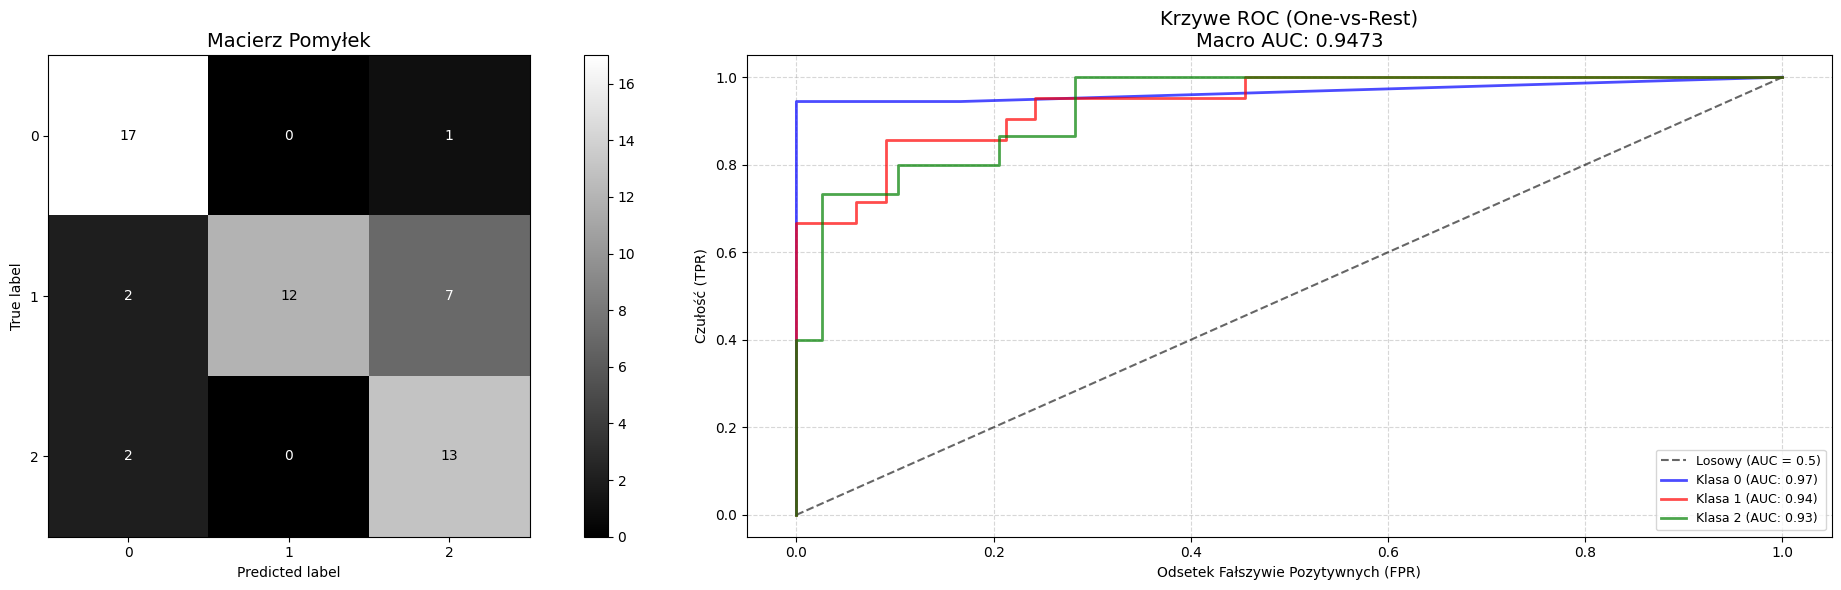

,Klasa,Recall,Precision,Specifity,AUC_score
0,0,0.944444,0.809524,0.888889,0.967593
1,1,0.571429,1.000000,1.000000,0.940837
2,2,0.866667,0.619048,0.794872,0.933333
3,Macro-Avg,0.794180,0.809524,0.894587,0.947254
4,Accuracy (overall),0.777778,0.777778,0.777778,0.777778


In [27]:
y_pred = better_knn.predict(X_test)
y_scores = better_knn.predict_proba(X_test)

model_performence['better KNN'] = metrics_multiclass(y_test, y_pred, y_scores, 'better knn')
model_performence['better KNN']

In [22]:
## Optimazing LDA

In [23]:
def object_LDA(trial):
    solver = trial.suggest_categorical('solver', ['lsqr', 'eigen'])
    shrinkage = trial.suggest_float('shrinkage', 0, 1, log=False)

    clf = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=cv, scoring='accuracy').mean()
    return score


LDA_study = optuna.create_study(direction='maximize')
LDA_study.optimize(object_LDA, n_trials=100)

LDA_study.best_params

[I 2025-11-25 14:42:30,008] A new study created in memory with name: no-name-6584806a-bdf8-43cc-a2e6-816f9bb1e093
[I 2025-11-25 14:42:30,026] Trial 0 finished with value: 0.71 and parameters: {'solver': 'lsqr', 'shrinkage': 0.7814384864721168}. Best is trial 0 with value: 0.71.
[I 2025-11-25 14:42:30,044] Trial 1 finished with value: 0.6856666666666666 and parameters: {'solver': 'eigen', 'shrinkage': 0.34624737200908695}. Best is trial 0 with value: 0.71.
[I 2025-11-25 14:42:30,063] Trial 2 finished with value: 0.71 and parameters: {'solver': 'eigen', 'shrinkage': 0.890405834017181}. Best is trial 0 with value: 0.71.
[I 2025-11-25 14:42:30,083] Trial 3 finished with value: 0.6773333333333332 and parameters: {'solver': 'eigen', 'shrinkage': 0.318720931954387}. Best is trial 0 with value: 0.71.
[I 2025-11-25 14:42:30,104] Trial 4 finished with value: 0.7016666666666667 and parameters: {'solver': 'eigen', 'shrinkage': 0.5841628569991019}. Best is trial 0 with value: 0.71.
[I 2025-11-25 14

{'solver': 'lsqr', 'shrinkage': 0.00022841011904252645}

## Test Performance

In [24]:
better_LDA = LinearDiscriminantAnalysis(solver=LDA_study.best_params['solver'], shrinkage=LDA_study.best_params['shrinkage'])
better_LDA.fit(X_train, y_train)

LinearDiscriminantAnalysis(shrinkage=0.00022841011904252645, solver='lsqr')

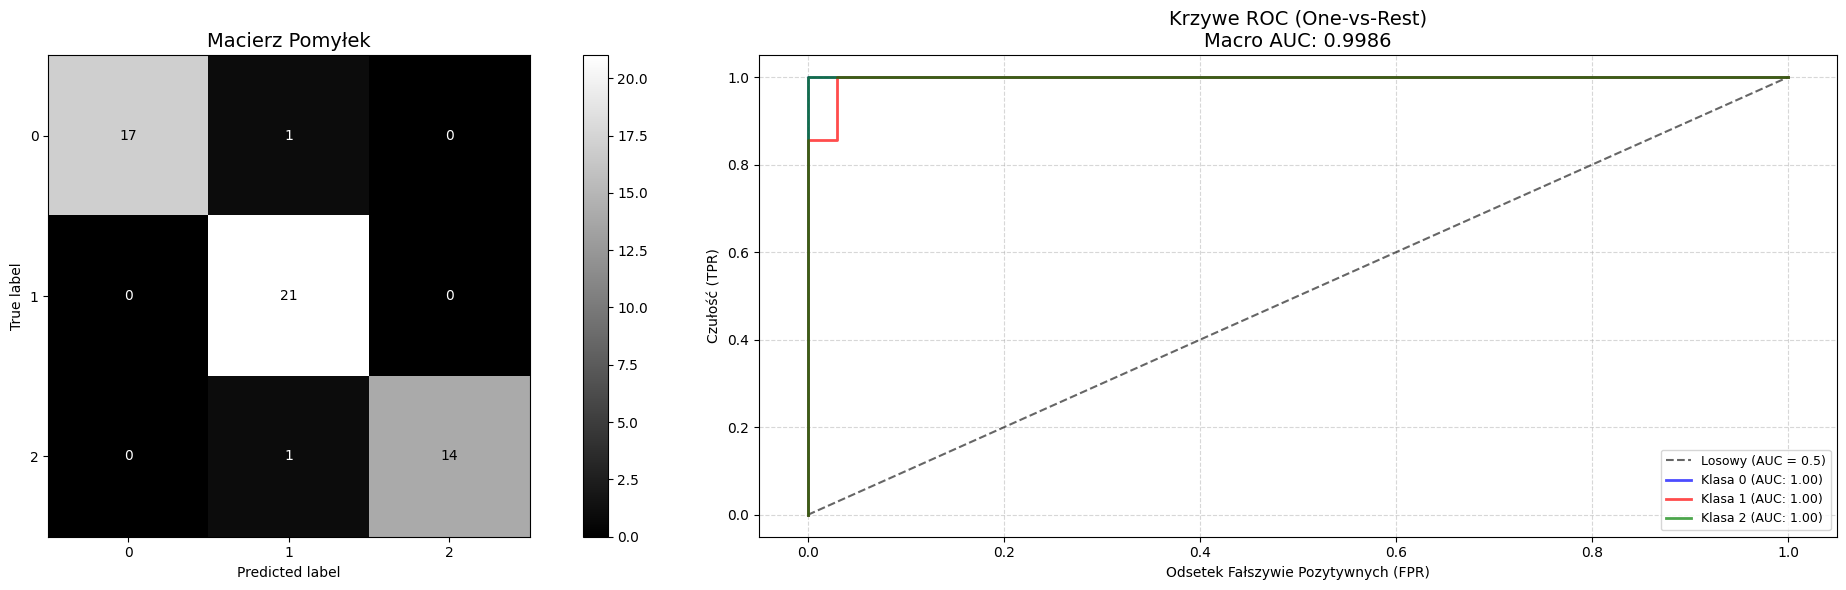

,Klasa,Recall,Precision,Specifity,AUC_score
0,0,0.944444,1.000000,1.000000,1.000000
1,1,1.000000,0.913043,0.939394,0.995671
2,2,0.933333,1.000000,1.000000,1.000000
3,Macro-Avg,0.959259,0.971014,0.979798,0.998557
4,Accuracy (overall),0.962963,0.962963,0.962963,0.962963


In [25]:
y_pred = better_LDA.predict(X_test)
y_scores = better_LDA.predict_proba(X_test)

model_performence['better LDA'] = metrics_multiclass(y_test, y_pred, y_scores, 'better LDA')
model_performence['better LDA']

# Summary

In [26]:
model_performence.keys()
models = ['Logistic', 'LDA', 'KNN']

summary = {}

for model in models:
    summary[model] = {"Base Model Accuracy": model_performence[f"{model} Base"]['AUC_score'].values[-1],
                      "Oprimized model Accuracy": model_performence[f"better {model}"]['AUC_score'].values[-1]}

summary_df = pd.DataFrame(summary)
summary_df

,Logistic,LDA,KNN
Base Model Accuracy,0.962963,0.981481,0.703704
Oprimized model Accuracy,0.944444,0.962963,0.777778
